# Diagrams
<img src= 'https://raw.githubusercontent.com/m-soro/Business-Analytics/main/SQL-for-Data-Analysis/L4-Project-Query-Music-Store/Misc/001.png' width=600/>

# The imports

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
import warnings
warnings.filterwarnings("ignore")

# Database connection details
database = 'testspace'
user = 'postgres'
password = '123'
host = 'localhost'
port = '5432'

# Create a database connection
engine = create_engine(f'postgresql://{user}:{password}@{host}:{port}/{database}')

In [2]:
# Join all tables into 1 dataframe to get a closer look at given datas
df = pd.read_sql_query('''
SELECT *
FROM public."Employee"
FULL JOIN public."Customer" ON public."Employee"."EmployeeId" = public."Customer"."SupportRepId"
FULL JOIN public."Invoice" ON public."Invoice"."CustomerId" = public."Customer"."CustomerId"
FULL JOIN public."InvoiceLine" ON public."Invoice"."InvoiceId" = public."InvoiceLine"."InvoiceId"
FULL JOIN public."Track" ON public."InvoiceLine"."TrackId" = public."Track"."TrackId"
FULL JOIN public."Genre" ON public."Track"."GenreId" = public."Genre"."GenreId"
FULL JOIN public."MediaType" ON public."Track"."MediaTypeId" = public."MediaType"."MediaTypeId"
FULL JOIN public."Album" ON public."Album"."AlbumId" = public."Track"."AlbumId"
FULL JOIN public."Artist" ON public."Album"."ArtistId" = public."Artist"."ArtistId"
FULL JOIN public."PlaylistTrack" ON public."PlaylistTrack"."TrackId" = public."Track"."TrackId"
FULL JOIN public."Playlist" ON public."Playlist"."PlaylistId" = public."PlaylistTrack"."PlaylistId"
;
''', engine)
df.head()

,EmployeeId,LastName,FirstName,Title,ReportsTo,BirthDate,HireDate,Address,City,State,...,Name,AlbumId,Title,ArtistId,ArtistId,Name,PlaylistId,TrackId,PlaylistId,Name
0,NaN,None,None,None,NaN,NaT,NaT,None,None,None,...,Protected MPEG-4 video file,271.0,Revelations,8.0,8.0,Audioslave,1.0,3402.0,1.0,Music
1,NaN,None,None,None,NaN,NaT,NaT,None,None,None,...,Protected AAC audio file,271.0,Revelations,8.0,8.0,Audioslave,1.0,3389.0,1.0,Music
2,NaN,None,None,None,NaN,NaT,NaT,None,None,None,...,Protected AAC audio file,271.0,Revelations,8.0,8.0,Audioslave,1.0,3390.0,1.0,Music
3,3.0,Peacock,Jane,Sales Support Agent,2.0,1973-08-29,2002-04-01,1111 6 Ave SW,Calgary,AB,...,Protected AAC audio file,271.0,Revelations,8.0,8.0,Audioslave,1.0,3391.0,1.0,Music
4,3.0,Peacock,Jane,Sales Support Agent,2.0,1973-08-29,2002-04-01,1111 6 Ave SW,Calgary,AB,...,Protected AAC audio file,271.0,Revelations,8.0,8.0,Audioslave,1.0,3392.0,1.0,Music


In [3]:
df.shape

(9432, 64)

In [4]:
df = df.dropna()

In [5]:
#Check Non-Null count, data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589 entries, 74 to 9342
Data columns (total 64 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   EmployeeId         589 non-null    float64       
 1   LastName           589 non-null    object        
 2   FirstName          589 non-null    object        
 3   Title              589 non-null    object        
 4   ReportsTo          589 non-null    float64       
 5   BirthDate          589 non-null    datetime64[ns]
 6   HireDate           589 non-null    datetime64[ns]
 7   Address            589 non-null    object        
 8   City               589 non-null    object        
 9   State              589 non-null    object        
 10  Country            589 non-null    object        
 11  PostalCode         589 non-null    object        
 12  Phone              589 non-null    object        
 13  Fax                589 non-null    object        
 14  Email   

# Analyzing sales by country

To analyze the countries with the highest sales, we need to consider the following metrics for each country:

- Total number of customers: This refers to the overall count of customers from each country.

- Total sales: It represents the sum of sales generated from each country.

- Average value of sales per customer: This metric calculates the average sales amount per customer in each country.

- Average order value: It indicates the average value of each order placed by customers from each country.

Additionally, it's worth noting that there are several countries with only one customer each. To simplify the analysis, we can group these countries together as "Other."

By considering these factors, we can gain a comprehensive understanding of the sales performance in different countries.

In [6]:
t1 = pd.read_sql_query('''
WITH
    country_with_one_customer AS
        (SELECT
            i."BillingCountry" AS country,
            COUNT(DISTINCT i."CustomerId")
        FROM public."Invoice" AS i
        GROUP BY country
        HAVING COUNT(DISTINCT i."CustomerId") = 1),
    country_or_other AS
        (SELECT
            (CASE
                WHEN i."BillingCountry" IN (SELECT country FROM country_with_one_customer) THEN 'Others'::varchar
                ELSE i."BillingCountry"
            END) AS country,
            (CASE
                WHEN i."BillingCountry" IN (SELECT country FROM country_with_one_customer) THEN 1
                ELSE 0
            END) AS sort,
            i.*
        FROM public."Invoice" AS i)
SELECT
    DISTINCT country,
    COUNT(DISTINCT a."CustomerId") AS total_customers,
    SUM(a."Total") AS total_sales, 
    SUM(a."Total")/COUNT(DISTINCT a."CustomerId") AS avg_sale_per_customer,
    SUM(a."Total")/COUNT(DISTINCT a."InvoiceId") AS avg_order_value,
    a.sort
FROM country_or_other AS a
GROUP BY country, a.sort
ORDER BY sort ASC , total_sales DESC
''',engine)
t1

,country,total_customers,total_sales,avg_sale_per_customer,avg_order_value,sort
0,USA,13,523.06,40.235385,5.747912,0
1,Canada,8,303.96,37.995000,5.427857,0
2,France,5,195.10,39.020000,5.574286,0
3,Brazil,5,190.10,38.020000,5.431429,0
4,Germany,4,156.48,39.120000,5.588571,0
5,United Kingdom,3,112.86,37.620000,5.374286,0
6,Czech Republic,2,90.24,45.120000,6.445714,0
7,Portugal,2,77.24,38.620000,5.517143,0
8,India,2,75.26,37.630000,5.789231,0
9,Others,15,604.30,40.286667,5.755238,1


Text(0.5, 1.0, 'Average Order Value by Country')

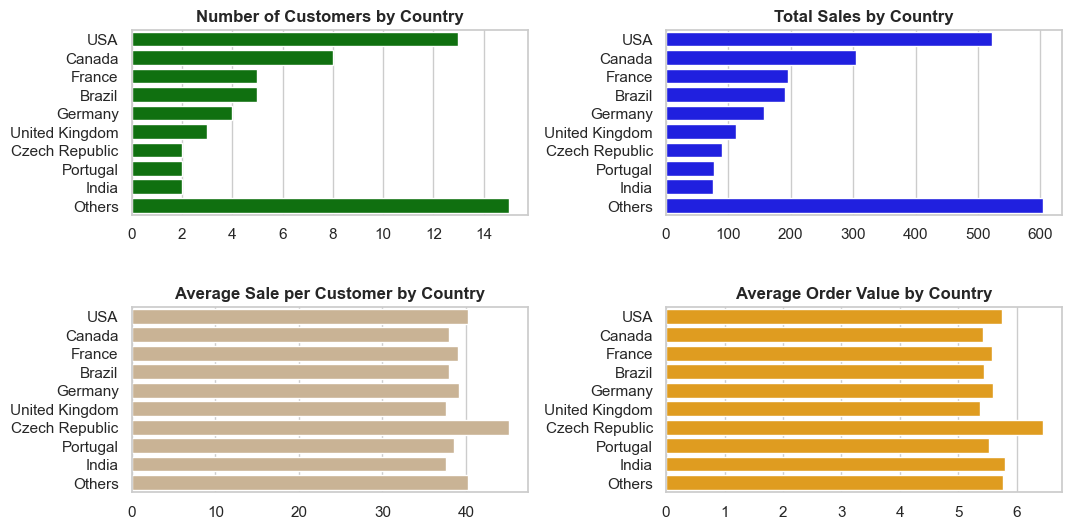

In [7]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
sns.barplot(t1,y='country', x='total_customers', color="green")
plt.xlabel('')
plt.ylabel('')
plt.title('Number of Customers by Country',
         fontdict= {'fontweight':'bold'})

plt.subplot(2,2,2)
sns.barplot(t1,y='country', x='total_sales', color="blue")
plt.subplots_adjust(wspace=0.35)
plt.xlabel('')
plt.ylabel('')
plt.title('Total Sales by Country',
         fontdict= {'fontweight':'bold'})

plt.subplot(2,2,3)
sns.barplot(t1,y='country', x='avg_sale_per_customer', color="tan")
plt.subplots_adjust(hspace=0.5, wspace=0.35)
plt.xlabel('')
plt.ylabel('')
plt.title('Average Sale per Customer by Country',
         fontdict= {'fontweight':'bold'})

plt.subplot(2,2,4)
sns.barplot(t1,y='country', x='avg_order_value', color="orange")
plt.subplots_adjust(hspace=0.5, wspace=0.35)
plt.xlabel('')
plt.ylabel('')
plt.title('Average Order Value by Country',
         fontdict= {'fontweight':'bold'})

Upon examining the data, it appears that the average sale per customer and average order value are relatively similar across countries. In light of this, it would be beneficial for the company to concentrate its efforts on countries with a substantial customer base, specifically the USA and Canada. The category labeled as "Others" consists of countries with only one customer each, making it less significant in terms of providing meaningful insights.

In [8]:
avg_order_value_mean = t1[['avg_order_value']].mean()
test1 = t1[['country']]
test1[['%_difference_from_mean']]= ((t1[['avg_order_value']]-avg_order_value_mean)/avg_order_value_mean)*100
test1=test1.sort_values('%_difference_from_mean', ascending=False)
test1=test1.reset_index(drop=True)

In [9]:
test1

,country,%_difference_from_mean
0,Czech Republic,13.778017
1,India,2.189946
2,Others,1.589917
3,USA,1.460600
4,Germany,-1.352039
5,France,-1.604206
6,Portugal,-2.612877
7,Brazil,-4.125882
8,Canada,-4.188924
9,United Kingdom,-5.134552


Text(0, 0.5, '')

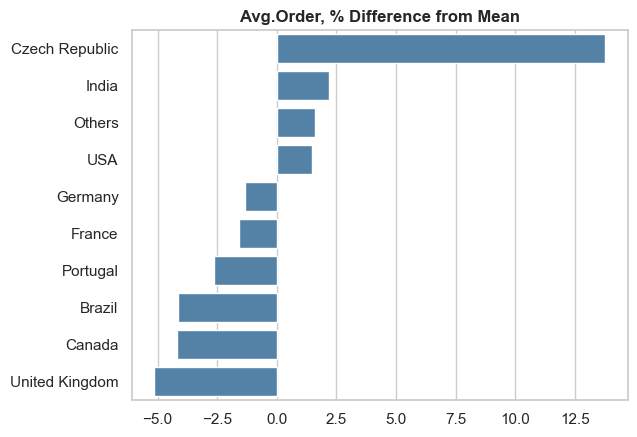

In [31]:
sns.barplot(test1, y='country', x='%_difference_from_mean', color='steelblue')
plt.title('Avg.Order, % Difference from Mean',
          fontdict= {'fontweight':'bold'})

plt.xlabel('')
plt.ylabel('')

To summarize, the analysis of sales across different countries reveals that a significant portion of sales takes place in **North America**, specifically **the USA and Canada**, which together make up **approximately 34% of all customers and sales**. On the other hand, countries like the **Czech Republic, the United Kingdom, and Brazil** have relatively fewer customers, but **their average orders are among the highest compared to other countries**. This suggests a potential business opportunity for Chinook store in these three countries. However, it's important to note that the current analysis is based on a limited data sample. To validate the observed trend in this project, the store should consider collecting and analyzing customer data from small marketing campaigns conducted in these three countries.

# Identifying Popular Music Genres

Having understood the countries in which Chinook store sells most, let’s identify the popular music genres among customers in the top five countries which account for most customers and sales: **USA, Canada, Brazil, France, and Germany.**

In [18]:
t2 = pd.read_sql_query('''
WITH 
    popular_genre AS
    (
        SELECT
            g."Name" AS genre,
            COUNT(*) AS tracks_sold
        FROM public."Genre" AS g 
        INNER JOIN public."Track" AS t ON g."GenreId" = t."GenreId"
        INNER JOIN public."InvoiceLine" AS il ON il."TrackId" = t."TrackId"
        INNER JOIN public."Invoice" AS i ON i."InvoiceId" = il."InvoiceId"
        WHERE i."BillingCountry" IN ('USA', 'Canada', 'Brazil', 'France', 'Germany')
        GROUP BY 1)
SELECT
    genre,
    tracks_sold,
    CAST (tracks_sold AS FLOAT)/(SELECT SUM(tracks_sold) FROM popular_genre)*100 AS tracks_sold_pct
FROM popular_genre
ORDER BY 2 DESC
LIMIT 10;
''',engine)
t2

,genre,tracks_sold,tracks_sold_pct
0,Rock,472,35.488722
1,Latin,248,18.646617
2,Metal,164,12.330827
3,Alternative & Punk,137,10.300752
4,Jazz,48,3.609023
5,Blues,41,3.082707
6,Classical,29,2.180451
7,R&B/Soul,20,1.503759
8,Reggae,20,1.503759
9,TV Shows,19,1.428571


Text(0, 0.5, '')

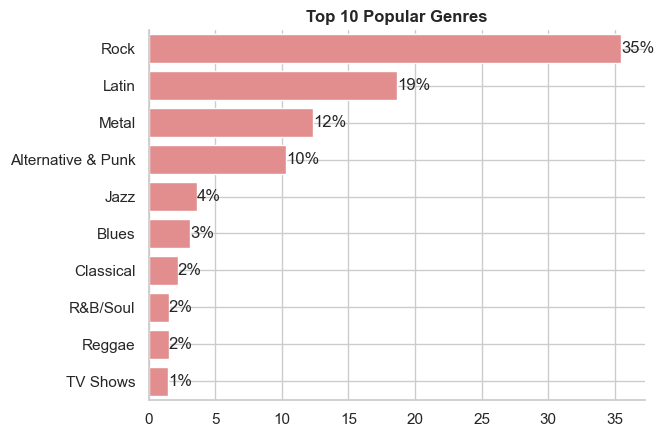

In [30]:
sns.barplot(t2, y='genre', x='tracks_sold_pct', color='lightcoral')
plt.title('Top 10 Popular Genres',
          fontdict= {'fontweight':'bold'})

#Dennotation
for index, row in t2.iterrows():
    plt.text(row['tracks_sold_pct'], index, str(round(row['tracks_sold_pct']))+'%', va='center')

plt.grid(True)
sns.despine()
plt.xlabel('')
plt.ylabel('')

Based on the analyses conducted, it is evident that the **Rock genre** is the most favored among customers, **constituting over half (54%) of all track purchases**. Additionally, genres like **Metal and Alternative & Punk** are also popular, collectively **accounting for 23% of track sales**. Therefore, if the Chinook store intends to market tracks that have a high likelihood of selling well, it would be wise to prioritize these three genres: Rock, Metal, and Alternative & Punk. By focusing on these popular genres, the store can better cater to customer preferences and maximize their sales potential.

# Analyzing Album vs Tracks Sales

<img src= 'https://raw.githubusercontent.com/m-soro/Business-Analytics/main/SQL-for-Data-Analysis/L4-Project-Query-Music-Store/Misc/001.png' width=600/>